In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import cv2
import math
import random

In [ ]:
!pip install --upgrade --quiet youtube_dl

     |████████████████████████████████| 1.9MB 8.9MB/s 


In [ ]:
from __future__ import unicode_literals
import youtube_dl


class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


def my_hook(d):
    if d['status'] == 'finished':
        print('Done downloading.')

def download_youtube_video(_url):
  ydl_opts = {
      'format': '(mp4)[height>=256][height<=400]',
      'outtmpl': '%(id)s.%(ext)s',
      'logger': MyLogger(),
      'progress_hooks': [my_hook],
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
      result = ydl.extract_info(_url, download=True)

  if 'entries' in result:
    video = result['entries'][0]
  else:
    video = result

  return video

def analyse_video(_videoPath):
  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameCount = 0
  darkFrames = []
  validFrames = []

  while success:
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    average = grey.mean(axis=0).mean(axis=0)

    if average < 2:
      darkFrames.append(frameCount)
    else:
      validFrames.append(frameCount)
    
    success, frame = vidcap.read()
    frameCount += 1
  
  print(f'Found {len(darkFrames)} dark frames.')
  return validFrames, darkFrames

def extract_frames(_videoPath, _outputPath, _num, _size):
  SIZE = _size[0]
  MAX = _num
  count = 0
  id = 0
  validFrames, darkFrames = analyse_video(_videoPath)
  doubles = []
  frames = []

  if MAX > len(validFrames):
    numDoubles = MAX - len(validFrames)
    doubles = np.random.choice(validFrames, size=numDoubles, replace=False)
    frames = validFrames
  else:
    frames = np.random.choice(validFrames, size=MAX, replace=False)

  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  scaleFactor = SIZE / frameHeight
  newWidth = int(frameWidth * scaleFactor)
  padding = int((newWidth - SIZE) / 2)

  while success:
    if count in frames:
      frame = cv2.resize(frame, (newWidth, SIZE), interpolation=cv2.INTER_AREA)
      crops = []

      if count in doubles:
        crops = [frame[0:SIZE, 0:SIZE],
                frame[0:SIZE, padding*2:SIZE+padding*2]]
      else:
        crops = [frame[0:SIZE, padding:SIZE+padding]]

      for crop in crops:
        try:
          cv2.imwrite(os.path.join(_outputPath, f'{id:04}.jpg'), crop)
          id += 1
        except:
          print("Error saving frame.")
          pass
    
    count += 1
    success, frame = vidcap.read()

  print(f"Saved {id} images from video '{videoInfo['title']}'")

  return id

In [ ]:
url = 'https://www.youtube.com/watch?v=cJwkPjhLFF0'
videoInfo = download_youtube_video(url)
videoFile = "{0}.{1}".format(videoInfo['webpage_url'].split('=')[-1], videoInfo['ext'])

Done downloading.


In [ ]:
DATASET_DIR = 'dataset'
IMAGES_DIR = f"{DATASET_DIR}/images"
OUTPUT_DIR = 'output'
IMAGE_SIZE =(64, 64)
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(IMAGES_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass
NUM_IMAGES = extract_frames(f"/content/{videoFile}", IMAGES_DIR, 3000, IMAGE_SIZE)

Found 0 dark frames.
Saved 3000 images from video '4K RAINBOW & CLOUDS 🌈  Live Wallpaper 🌤  Orbs Field 🌐 #AAVFX Moving Background'


In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR, label_mode=None, image_size=IMAGE_SIZE, batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 3000 files belonging to 1 classes.


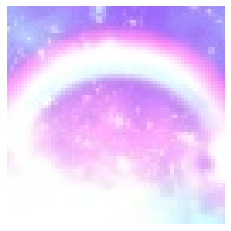

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


In [ ]:
epochs = 60

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/60
94/94 [==============================] - 64s 275ms/step - d_loss: 0.2641 - g_loss: 5.3900
Epoch 2/60
94/94 [==============================] - 25s 262ms/step - d_loss: 0.4187 - g_loss: 4.0300
Epoch 3/60
94/94 [==============================] - 25s 265ms/step - d_loss: 0.2083 - g_loss: 2.9232
Epoch 4/60
94/94 [==============================] - 25s 269ms/step - d_loss: 0.0614 - g_loss: 4.4252
Epoch 5/60
94/94 [==============================] - 26s 273ms/step - d_loss: 0.0472 - g_loss: 5.0088
Epoch 6/60
94/94 [==============================] - 26s 275ms/step - d_loss: 0.0712 - g_loss: 4.3309
Epoch 7/60
94/94 [==============================] - 26s 278ms/step - d_loss: 0.1085 - g_loss: 3.7916
Epoch 8/60
94/94 [==============================] - 26s 279ms/step - d_loss: 0.5802 - g_loss: 1.5707
Epoch 9/60
94/94 [==============================] - 26s 280ms/step - d_loss: 0.6516 - g_loss: 1.3785
Epoch 10/60
94/94 [==============================] - 27s 281ms/step - d_loss: 0.6020 - g_lo

In [ ]:
os.mkdir('model')
gan.generator.save('model')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/model/ /content/drive/MyDrive/

In [ ]:
my_images = []
for root, dirs, files in os.walk(OUTPUT_DIR, topdown=False):
    for name in files:
        if not ".DS_Store" in name:
            my_images.append(os.path.join(root, name))
    my_images =np.array(my_images)

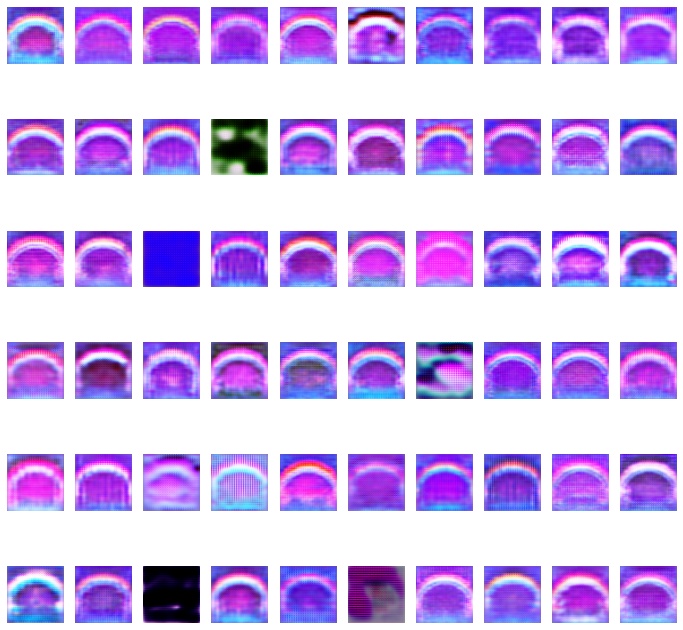

In [ ]:
num_to_show = len(my_images)
plt.figure(figsize=(12,12))
cols = 10
rows = int(np.ceil(num_to_show / cols))
for index, im in enumerate(my_images):
    loaded_image = cv2.cvtColor(cv2.resize(cv2.imread(im), IMAGE_SIZE), cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, index+1)
    plt.imshow(loaded_image, interpolation="bilinear")
    plt.axis('off')
plt.show()

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model

 # generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  return asarray(vectors)

# create a plot of generated images
def plot_generated(examples):
  # plot images
  num_to_show = len(examples)
  plt.figure(figsize=(12,12))
  cols = 3
  rows = int(np.ceil(num_to_show / cols))
  for i in range(num_to_show):
    # define subplot
    plt.subplot(rows, cols, i+1)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i])
  plt.show()

(2, 128)


<Figure size 864x864 with 0 Axes>

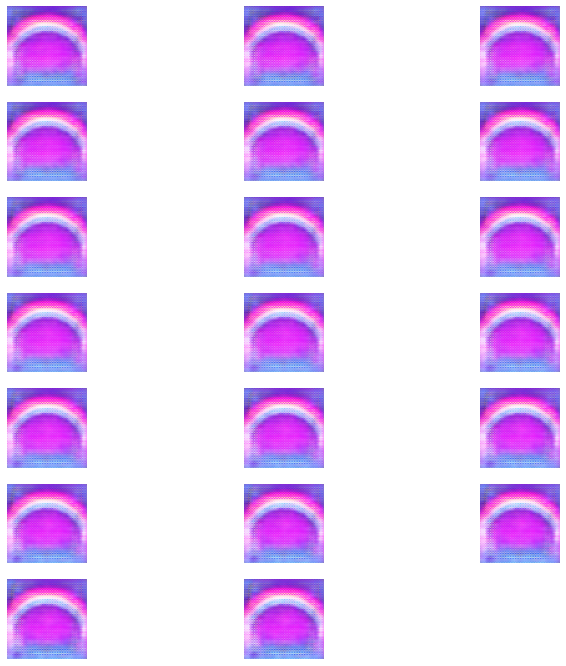

In [ ]:
num_images = 20

# generate points in latent space
pts = generate_latent_points(latent_dim, 2)
print(pts.shape)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1], num_images)
# generate images
X = gan.generator(interpolated)
X *= 255
X.numpy()
generated_images = []
for i in range(num_images):
    generated_images.append(keras.preprocessing.image.array_to_img(X[i]))
plt.figure(figsize=(12,12))
plot_generated(generated_images)